In [1]:
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

data_wd = Path('/data') / 'raspi_face_detection'
img_path = data_wd / 'images'
labels_path = data_wd / 'labels'

model_sets_path = data_wd / 'model_sets'
aug_sets_path = data_wd / 'aug_data'

In [2]:
facetracker = load_model('facetracker.h5')

2024-05-08 18:07:37.650994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 18:07:37.656052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 18:07:37.656212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 18:07:37.656799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

ning NUMA node zero
2024-05-08 18:07:37.990132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 18:07:37.990299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 18:07:37.990433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 18:07:37.990541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21111 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


#### 11.2.1 Single Photo

In [3]:
final_test_wd = data_wd / 'final_test_images'
img_gen = final_test_wd.glob('*.jpg')

2024-05-08 18:07:39.031566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8902
2024-05-08 18:07:39.097520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 18:07:39.097896: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 18:07:39.097910: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-08 18:07:39.098473: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 18:07:39.098502: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-08 18:07:39.303632: I tensorflow/stream_executor/cuda/c

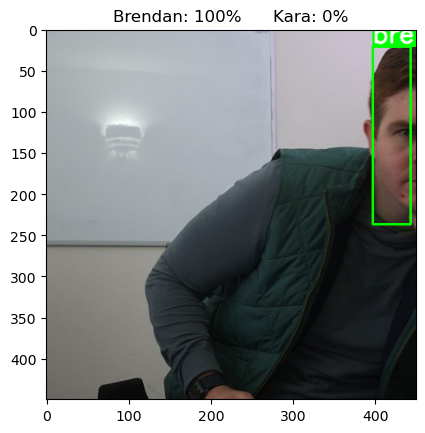

In [4]:
frame_captured = cv2.imread(str(next(img_gen)))
plt.imshow(frame_captured)

# cap = cv2.VideoCapture(0)
# _, frame_captured = cap.read()

frame = frame_captured[30:500, 50:500,:]

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(frame, (120,120))

frame_size = frame.shape[0:2]

yhat = facetracker.predict(np.expand_dims(resized/255,0))
labels, sample_coords = [x[0] for x in yhat]
labels, sample_coords

if yhat[0][0][0] > 0.7:
    # Controls the main rectangle
    cv2.rectangle(frame, 
                  tuple(np.multiply(sample_coords[0:2], frame_size).astype(int)),
                  tuple(np.multiply(sample_coords[2:4], frame_size).astype(int)), 
                        (0,255,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[0:2], frame_size).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[0:2], frame_size).astype(int),
                                [130,0])), 
                        (0,255,0), -1)
    # Controls the text rendered
    cv2.putText(frame, 'brendan', tuple(np.add(np.multiply(sample_coords[0:2], frame_size).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
if yhat[0][0][1] > 0.9:
    # Controls the main rectangle
    cv2.rectangle(frame, 
                  tuple(np.multiply(sample_coords[4:6], frame_size).astype(int)),
                  tuple(np.multiply(sample_coords[6:8], frame_size).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[4:6], frame_size).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[4:6], frame_size).astype(int),
                                [70,0])), 
                        (255,0,0), -1)
    
    # Controls the text rendered
    cv2.putText(frame, 'kara', tuple(np.add(np.multiply(sample_coords[4:6], frame_size).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

im = plt.imshow(frame)
im.axes.set_title(f'Brendan: {labels[0]:,.0%}      Kara: {labels[1]:,.0%}')
plt.show()

### 11.3 Real Time Detection

In [5]:
(sample_coords * (frame.shape[0:2] * 4)).round().astype(int)

array([397,  21, 443, 237,   7,   4,   9,   7])

In [6]:
yhat

[array([[9.9962950e-01, 3.5401608e-04]], dtype=float32),
 array([[0.8831114 , 0.04745173, 0.9849873 , 0.52759683, 0.01492727,
         0.00909034, 0.01943334, 0.01496023]], dtype=float32)]

In [7]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[30:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    sample_coords_pixels = (sample_coords * (frame.shape[0:2] * 4)).round().astype(int)
    
    if yhat[0][0][0] > 0.9:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      sample_coords_pixels[0:2], sample_coords_pixels[2:4], 
                      (0,0,255), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                       sample_coords_pixels[0:2] + [0,-30], sample_coords_pixels[0:2] + [130,0],
                      (0,0,255), -1)
        # Controls the text rendered
        cv2.putText(frame, 'brendan', sample_coords_pixels[0:2] + (0,-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    if yhat[0][0][1] > 0.9:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      sample_coords_pixels[4:6], sample_coords_pixels[6:8], 
                      (0,255,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      sample_coords_pixels[4:6] + [0,-30], sample_coords_pixels[4:6] + [70,0], 
                      (0,255,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'kara', sample_coords_pixels[4:6] + [0,-5],
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()